In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from models import BasicBlock, ResNet
from metrics import PredictionDepth
torch.autograd.set_detect_anomaly(True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet(BasicBlock, [2, 2, 2, 2], temp=1.0, num_classes=len(classes))
metric = PredictionDepth(model, device=device, layers=9)


In [5]:
metric.train(trainloader, epochs=1)

Epoch 0



100%|██████████| 196/196 [04:50<00:00,  1.48s/it]


In [6]:
model.get_num_layers()

11

In [7]:
indices, metrics = metric.get_metric(testset)

print(indices.size(), metrics.size())

100%|██████████| 40/40 [00:02<00:00, 18.58it/s]
40it [00:57,  1.45s/it]
100%|██████████| 40/40 [00:01<00:00, 30.49it/s]
40it [00:57,  1.45s/it]
100%|██████████| 40/40 [00:01<00:00, 29.80it/s]
40it [00:29,  1.36it/s]
100%|██████████| 40/40 [00:01<00:00, 27.17it/s]
40it [00:29,  1.36it/s]
100%|██████████| 40/40 [00:01<00:00, 28.66it/s]
40it [00:15,  2.63it/s]
100%|██████████| 40/40 [00:01<00:00, 31.59it/s]
40it [00:15,  2.63it/s]
100%|██████████| 40/40 [00:01<00:00, 28.17it/s]
40it [00:08,  4.86it/s]
100%|██████████| 40/40 [00:01<00:00, 28.61it/s]
40it [00:08,  4.86it/s]
100%|██████████| 40/40 [00:01<00:00, 27.76it/s]
40it [00:01, 29.56it/s]

torch.Size([10000]) torch.Size([10000])


In [8]:
torch.bincount(metrics.int())

tensor([   0,    0, 1802,  276,  240,  275,  154,  137,  202,  373,  868, 5673],
       device='cuda:0')

In [9]:
torch.unique(metrics.int())

tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11], device='cuda:0',
       dtype=torch.int32)

In [10]:
metrics.min(), metrics.max()

(tensor(2., device='cuda:0'), tensor(11., device='cuda:0'))

Images with the lowest VoG scores:


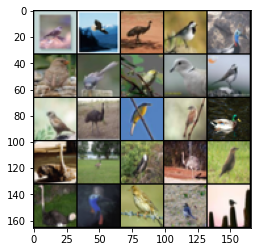

Images with the highest VoG scores:


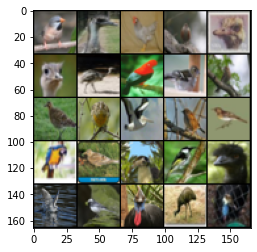

In [15]:
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def select_images_by_class(dataset, target_class):
    selected_images = []
    selected_labels = []

    for i in range(len(dataset)):
        image, label = dataset[i]
        if label == target_class:
            selected_images.append(image)
            selected_labels.append(label)

    return selected_images, selected_labels

def plot_extreme_vog_images(testset, indices, vog_scores, target_class, num_images=25):
    # Sort images by VoG scores
    sorted_indices = np.argsort(vog_scores)
    
    # Filter sorted_indices to only include indices of images that belong to the target class
    sorted_indices = [i for i in sorted_indices if testset[i][1] == target_class]
    
    # Select the top and bottom images
    lowest_vog_indices = sorted_indices[:num_images]
    highest_vog_indices = sorted_indices[-num_images:]
    
    # Create a dataset with the selected images
    lowest_vog_images = torch.stack([testset[i][0] for i in lowest_vog_indices])
    highest_vog_images = torch.stack([testset[i][0] for i in highest_vog_indices])

    # Plot the images with the lowest VoG scores
    print("Images with the lowest VoG scores:")
    imshow(vutils.make_grid(lowest_vog_images, nrow=num_images // 5, padding=1, normalize=True))

    # Plot the images with the highest VoG scores
    print("Images with the highest VoG scores:")
    imshow(vutils.make_grid(highest_vog_images, nrow=num_images // 5, padding=1, normalize=True))

# Visualize the 25 images with the lowest and highest VoG scores
plot_extreme_vog_images(trainset, indices.detach().cpu(), metrics.detach().cpu(), 2)
